In [1]:
import copy
import os
import time
import sqlalchemy
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from dotenv import load_dotenv

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_model import TractsModel

#from cities.modeling.zoning_models.zoning_tracts_continuous_interactions_model import TractsModelContinuousInteractions
from cities.modeling.zoning_models.zoning_tracts_population import TractsModelPopulation
from cities.utils.data_loader import select_from_data, ZoningDataset
from cities.modeling.waic import compute_waic

smoke_test = "CI" in os.environ

n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

from cities.modeling.svi_inference import run_svi_inference
from cities.modeling.zoning_models.zoning_tracts_model import TractsModel
from cities.utils.data_loader import select_from_sql


root = find_repo_root()

In [2]:



census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

ct_dataset_read = torch.load(census_tracts_data_path, weights_only=False)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))

kwargs = {
    "categorical": ["year", "census_tract", 'university_index', 'downtown_index'],
    "continuous": {
        "housing_units",
        "housing_units_original"
        "total_value",
        "total_population",
        "population_density",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        'limit',
        "segregation_original",
        "white_original",
        "parcel_sqm",
        'downtown_overlap', 
        'university_overlap',
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

print(subset['continuous'].keys())

dict_keys(['parcel_sqm', 'mean_limit_original', 'white_original', 'housing_units', 'income', 'university_overlap', 'segregation_original', 'total_population', 'median_distance', 'median_value', 'population_density', 'downtown_overlap'])


In [3]:
ins = [
    ("university_overlap", "limit"),
    ("downtown_overlap", "limit"),
    ("distance", "downtown_overlap"),
    ("distance", "university_overlap"),
    ("distance", "limit"),
    ("median_value", "segregation"),
    ("distance", "segregation"),
    ("limit", "sqm"),
    ("segregation", "sqm"),
    ("distance", "white"),
    ("income", "limit"),
    ("downtown_overlap", "median_value"),
    ("downtown_overlap", "segregation"),
    ("median_value", "white"),
    ("distance", "income"),
]

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


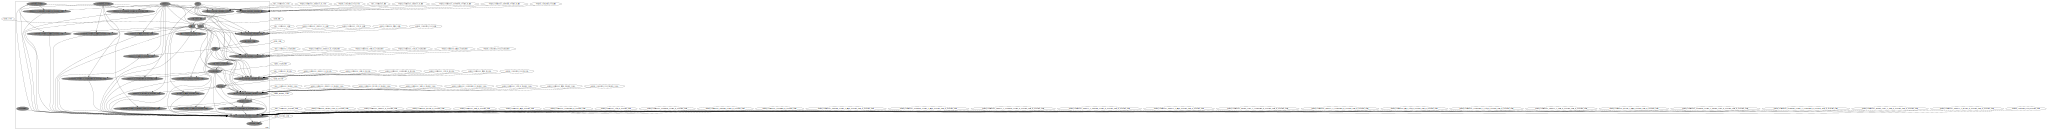

In [4]:
pyro.clear_param_store()

tracts_model = TractsModelPopulation(
    **subset,
    housing_units_continuous_interaction_pairs = ins
)

with pyro.poutine.trace() as tr:
    tracts_model(**subset)


assert tr.trace.nodes["housing_units"]["value"].shape == torch.Size([1130])

pyro.render_model(
    lambda: tracts_model(**subset),
    render_deterministic=True,
)

[iteration 0001] loss: 419832.4375
[iteration 0050] loss: 29168.0449
[iteration 0100] loss: 17062.8496
[iteration 0150] loss: 16380.7158
[iteration 0200] loss: 15238.1572
[iteration 0250] loss: 13583.9033
[iteration 0300] loss: 13450.5215
[iteration 0350] loss: 13263.1797
[iteration 0400] loss: 13123.7607
[iteration 0450] loss: 12852.0928
[iteration 0500] loss: 12678.4150
[iteration 0550] loss: 12690.7695
[iteration 0600] loss: 12656.0967
[iteration 0650] loss: 12587.4746
[iteration 0700] loss: 12631.2441
[iteration 0750] loss: 12545.4961
[iteration 0800] loss: 12603.6348
[iteration 0850] loss: 12388.3408
[iteration 0900] loss: 12435.0898
[iteration 0950] loss: 12439.8516
[iteration 1000] loss: 12349.5889
[iteration 1050] loss: 12408.9805
[iteration 1100] loss: 12333.0645
[iteration 1150] loss: 12361.2627
[iteration 1200] loss: 12302.7500
[iteration 1250] loss: 12326.3799
[iteration 1300] loss: 12272.1768
[iteration 1350] loss: 12281.7090
[iteration 1400] loss: 12286.4160
[iteration 14

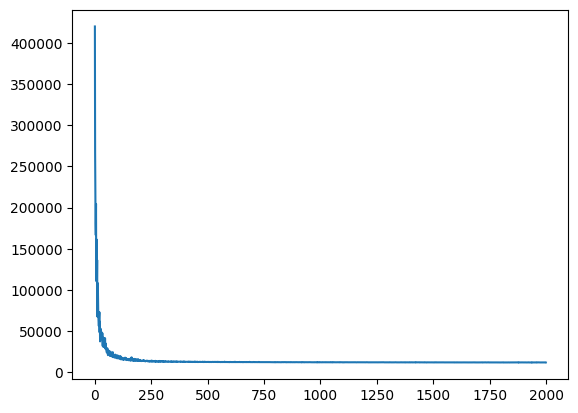

tensor(2943.1946, grad_fn=<MulBackward0>)


In [5]:
pyro.clear_param_store()
guide = run_svi_inference(tracts_model, n_steps=n_steps, lr=0.03, **subset)

waic = compute_waic(
    model=tracts_model,
    guide=guide,
    num_particles=10000,
    sites=["housing_units"],
    max_plate_nesting=9,
    **subset,
)

print(waic['waic'])  # interaction model: ca 2720-2780

# just population: seemingly higher, 2900,
# but crossvalidation results are slightly better than mere interactions model


[iteration 0001] loss: 206023.8906
[iteration 0050] loss: 41041.0820
[iteration 0100] loss: 21170.5840
[iteration 0150] loss: 17312.9375
[iteration 0200] loss: 13446.2529
[iteration 0250] loss: 12862.8936
[iteration 0300] loss: 11840.4951
[iteration 0350] loss: 11482.1777
[iteration 0400] loss: 9765.6553
[iteration 0450] loss: 10047.3516
[iteration 0500] loss: 9379.1006
[iteration 0550] loss: 9542.1484
[iteration 0600] loss: 8396.0635
[iteration 0650] loss: 8602.6426
[iteration 0700] loss: 8473.3584
[iteration 0750] loss: 8166.6299
[iteration 0800] loss: 8117.9741
[iteration 0850] loss: 7999.6670
[iteration 0900] loss: 7916.0171
[iteration 0950] loss: 7858.5742
[iteration 1000] loss: 7787.4443
[iteration 1050] loss: 7748.1353
[iteration 1100] loss: 7814.0479
[iteration 1150] loss: 7696.4536
[iteration 1200] loss: 7692.5854
[iteration 1250] loss: 7711.2373
[iteration 1300] loss: 7758.6440
[iteration 1350] loss: 7713.7686
[iteration 1400] loss: 7676.7329
[iteration 1450] loss: 7680.6313


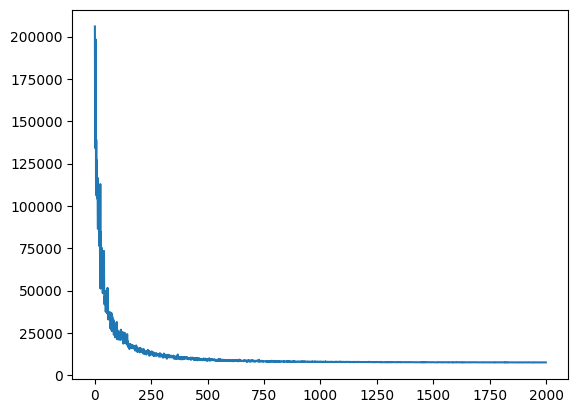

/home/rafal/s78projects/cities/cities/modeling/zoning_models/zoning_tracts_population.py:66: UserWarning: Passed categorical_levels will no longer override the levels passed to or computed during model initialization. The argument will be ignored.
  warnings.warn(


tensor(0.4274) tensor(0.3581)


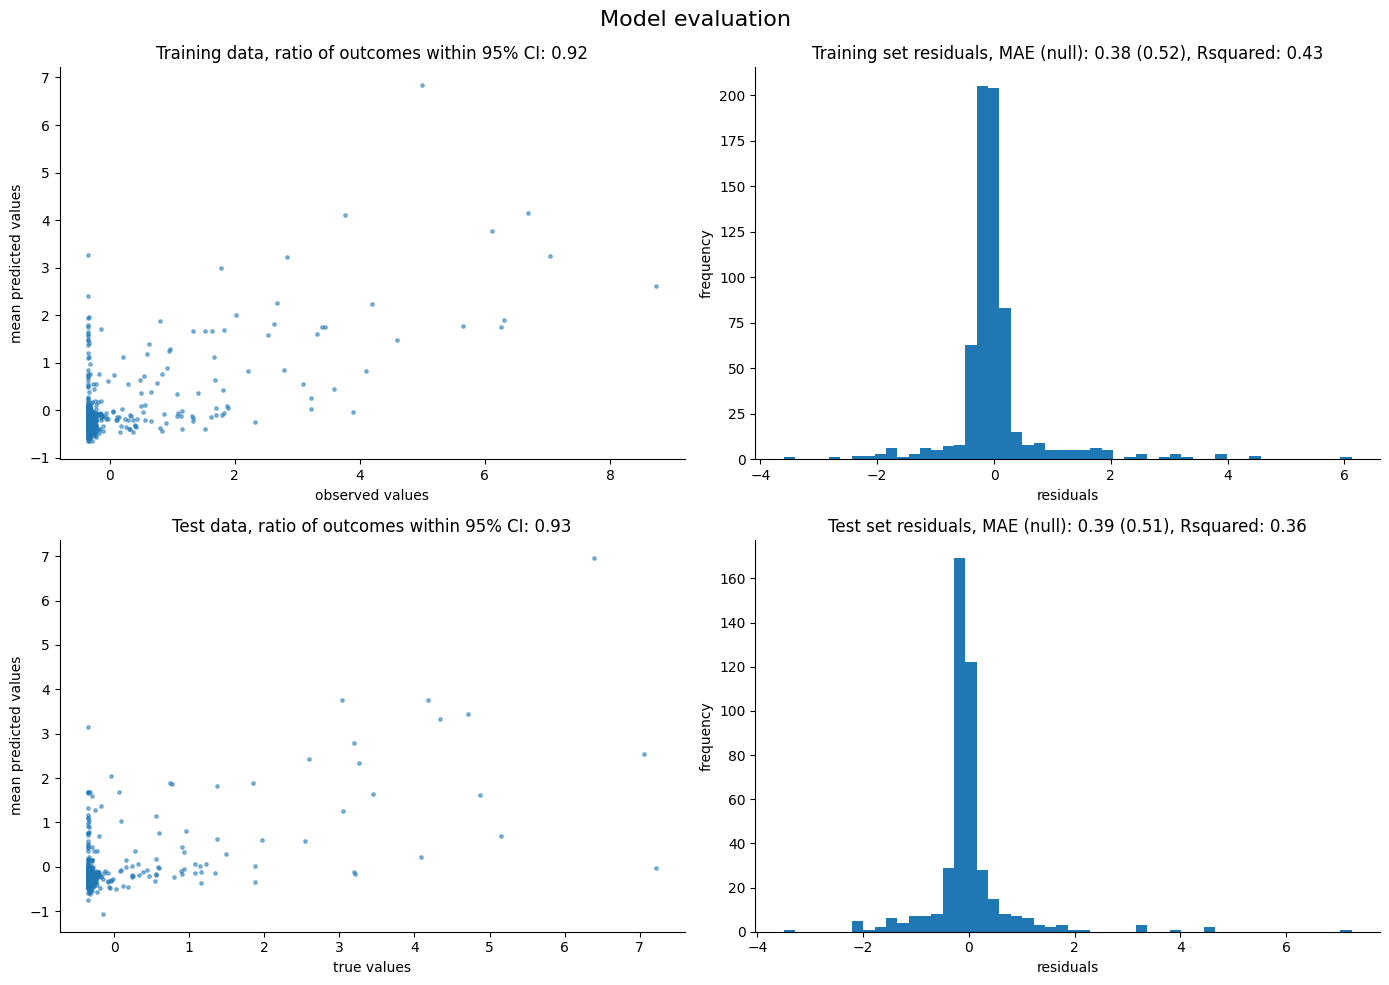

MAE improvements on the original scale: (tensor(42.), tensor(44.))


In [6]:
pyro.clear_param_store()


train_loader, test_loader, categorical_levels = prep_data_for_test(
    census_tracts_data_path, train_size=0.6
)

performance_results = test_performance(
    tracts_model,
    kwargs,
    train_loader,
    test_loader,
    categorical_levels,
    outcome_type="continuous",
    outcome_name="housing_units",
    n_steps=n_steps,
    plot=True,
    is_class=False,
)

def destandardize_housing_units(column):
    mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
    std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

    return (column * std + mean).round()


mae_improvement_train = destandardize_housing_units(
    performance_results["mae_null_train"] - performance_results["mae_train"]
)
mae_improvement_test = destandardize_housing_units(
    performance_results["mae_null_test"] - performance_results["mae_test"]
)

print(
    f"MAE improvements on the original scale: {mae_improvement_test, mae_improvement_train}"
)